<a href="https://colab.research.google.com/github/Alex-So-Ma/Deep_Learning/blob/main/IAF_Proyecto_Final_M2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clasificación de tumores cerebrales UNet
####Alejandro Soto Malpica

Base de datos obtenida de kaggle:
https://www.kaggle.com/datasets/thomasdubail/brain-tumors-256x256/data

Son imágenes obtenidas por resonacia magnética, en estas se observan los cerebros de pacientes sanos y con 3 tipos de tumores:

1. Glioma, son intra-axiales, o sea, crecen dentro de la sustancia blanda del cerebro.

2. Meningioma, este tumor parte de las meninges o membranas que envuelven y protegen el cerebro.

3. Tumores pituitarios, se desarrollan en la glándula pituitaria.

In [ ]:
#permitimos el acceso al drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Extensión tensorboard
%load_ext tensorboard

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from tensorboard.plugins.hparams import api as hp
import tensorflow as tf
from collections import OrderedDict, namedtuple
from itertools import product

from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from datetime import datetime
from matplotlib.pyplot import imshow

import pickle
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import matplotlib

from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import seaborn as sns
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import concatenate, add

%matplotlib inline
np.random.seed(1)

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices------------- 1


#Datos

Agregamos los dato a cuatro listas. Dos de entrenamiento y dos de prueba con las imágenes y sus respectivas etiquetas. El 10% de las imágenes van para prueba y el 90% para entrenamiento, esto de las 3096 imágenes. Sin embargo, por las limitaciones de memoria solo se puede trabajar con ~400 imágenes por clase.

In [ ]:
x_te, y_te= [], []
for file in os.listdir('/content/drive/MyDrive/Semestre 8/IAF/Data_v1/Data_test'):
    for image in os.listdir('/content/drive/MyDrive/Semestre 8/IAF/Data_v1/Data_test/'+str(file)):
        img = cv2.imread('/content/drive/MyDrive/Semestre 8/IAF/Data_v1/Data_test/'+str(file)+str('/')+str(image),0)
        x_te.append(img)
        y_te.append(file.replace('_test',''))

In [ ]:
x_tr, y_tr= [], []
for file in os.listdir('/content/drive/MyDrive/Semestre 8/IAF/Data_v1/Data_train'):
    c=0
    for image in os.listdir('/content/drive/MyDrive/Semestre 8/IAF/Data_v1/Data_train/'+str(file)):
        c=c+1
        img = cv2.imread('/content/drive/MyDrive/Semestre 8/IAF/Data_v1/Data_train/'+str(file)+str('/')+str(image),0)
        x_tr.append(img)
        y_tr.append(file.replace('_train',''))
        if c==400:
          break

Las cambiamos a numpy array.

In [ ]:
x_te = np.array(x_te)
y_te = np.array(y_te)
x_tr = np.array(x_tr)
y_tr = np.array(y_tr)

In [ ]:
x_te.shape, y_te.shape

((308, 256, 256), (308,))

In [ ]:
x_tr.shape, y_tr.shape

((1595, 256, 256), (1595,))

glioma_tumor


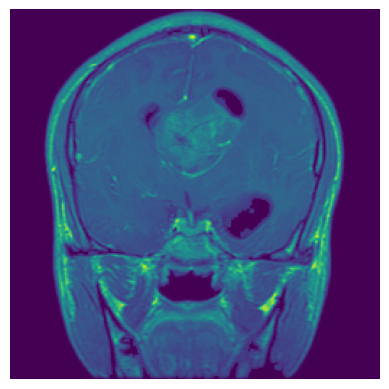

In [ ]:
n=0
plt.axis("off")
plt.imshow(x_tr[n])
print(y_tr[n])

meningioma_tumor


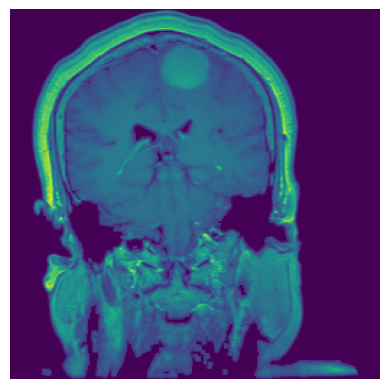

In [ ]:
n=400
plt.axis("off")
plt.imshow(x_tr[n])
print(y_tr[n])

normal


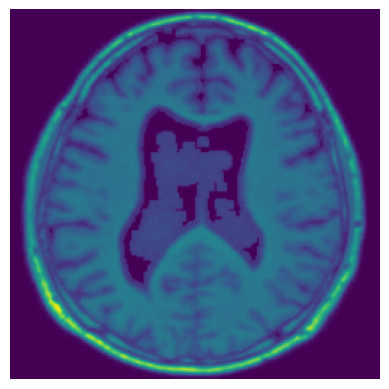

In [ ]:
n=900
plt.axis("off")
plt.imshow(x_tr[n])
print(y_tr[n])

pituitary_tumor


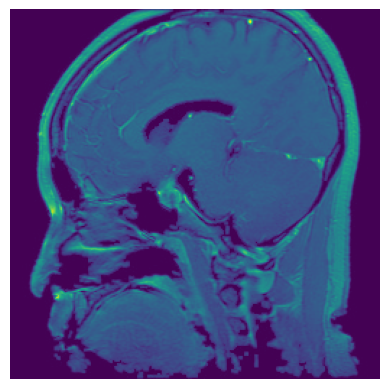

In [ ]:
n=1200
plt.axis("off")
plt.imshow(x_tr[n])
print(y_tr[n])

Veamos la cantidad de datos de cada tipo.

In [ ]:
df = pd.DataFrame(data = y_tr,
                  columns = ['label'])
df['label'].value_counts()

glioma_tumor        400
meningioma_tumor    400
pituitary_tumor     400
normal              395
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

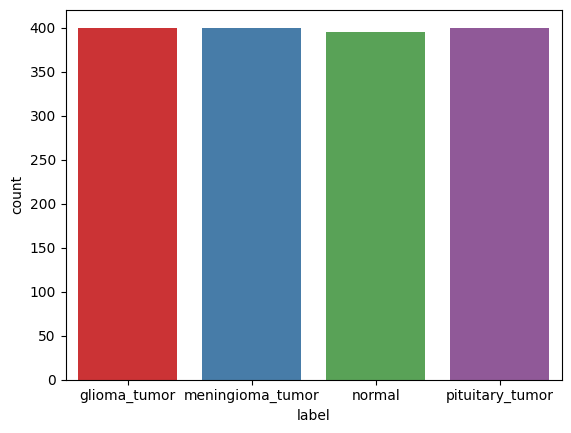

In [ ]:
sns.countplot(x = 'label', data = df, palette='Set1', width=0.8)

Codificación One-Hot.

In [ ]:
dic = {0: 'glioma', 1: 'meningioma', 2: 'normal', 3: 'pituitaria'}
ohe = LabelEncoder()

y_train = ohe.fit_transform(y_tr)
y_test = ohe.fit_transform(y_te)

In [ ]:
train_y = np.eye(4)[y_train.reshape(-1)]
test_y = np.eye(4)[y_test.reshape(-1)]

Normalizamos y reordenamos.

In [ ]:
x_train = x_tr.astype('float32') / 255.0
x_test = x_te.astype('float32') / 255.0

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

x_train, train_y = unison_shuffled_copies(x_train, train_y)

#UNet

Se diseñó en 2015 para procesar imágenes biomédicas. Localiza y distingue entre bordes clasificando cada pixel, de esta manera la imágen de entrada y salida son del mismo tamaño.

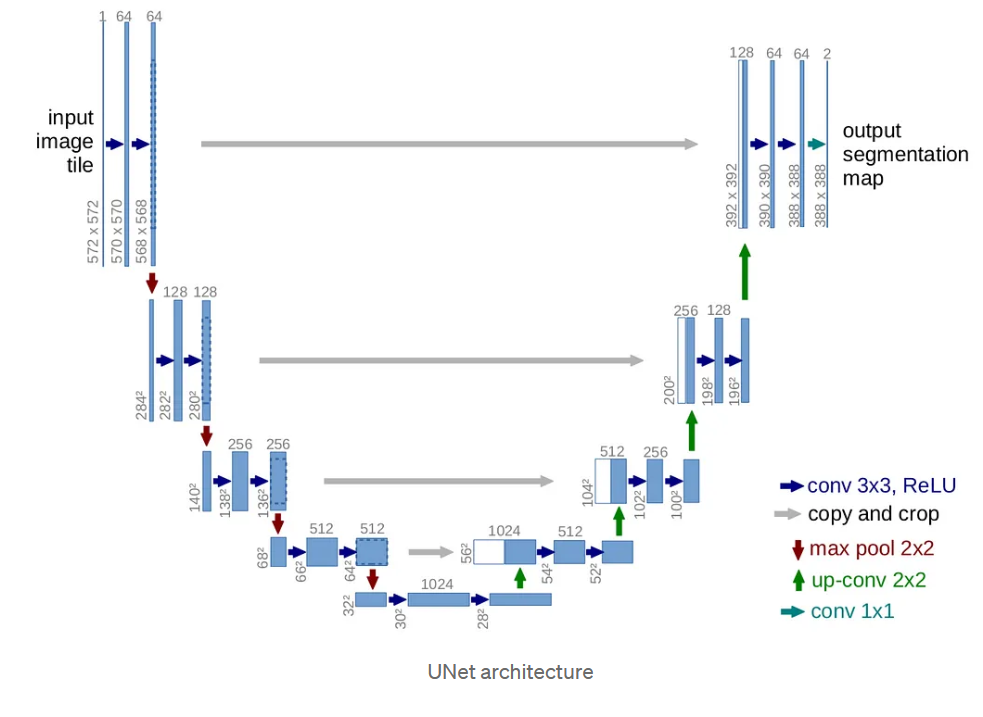

In [ ]:
n_of_n = 4
dp = 0.3

inputs = tf.keras.layers.Input((256, 256, 1))

#Se tienen dos partes la contractiva y la expansiva
#Las dos se repite un proceso 4 veces

# Parte contractiva
#   Dos capas convolucionales
conv1 = Conv2D(n_of_n * 1, (3, 3), activation="relu", padding="same")(inputs)
conv1 = Conv2D(n_of_n * 1, (3, 3), activation="relu", padding="same")(conv1)
#   Capa de maxpooling
pool1 = MaxPooling2D((2, 2))(conv1)
#   Dropout
pool1 = Dropout(dp*0.5)(pool1)

#   Lo anterior se repite 3 veces más, aumentando el número de filtros
conv2 = Conv2D(n_of_n * 2, (3, 3), activation="relu", padding="same")(pool1)
conv2 = Conv2D(n_of_n * 2, (3, 3), activation="relu", padding="same")(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)
pool2 = Dropout(dp)(pool2)

conv3 = Conv2D(n_of_n * 4, (3, 3), activation="relu", padding="same")(pool2)
conv3 = Conv2D(n_of_n * 4, (3, 3), activation="relu", padding="same")(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)
pool3 = Dropout(dp)(pool3)

conv4 = Conv2D(n_of_n * 8, (3, 3), activation="relu", padding="same")(pool3)
conv4 = Conv2D(n_of_n * 8, (3, 3), activation="relu", padding="same")(conv4)
pool4 = MaxPooling2D((2, 2))(conv4)
pool4 = Dropout(dp)(pool4)

# En el medio tenemos solo dos capas convulucionales, con el doble de filtros de la anterior
convm = Conv2D(n_of_n * 16, (3, 3), activation="relu", padding="same")(pool4)
convm = Conv2D(n_of_n * 16, (3, 3), activation="relu", padding="same")(convm)

# Parte expansiva
#   Capa de convolución transpuesta, aumenta el tamaño de la imágen
deconv4 = Conv2DTranspose(n_of_n * 8, (3, 3), strides=(2, 2), padding="same")(convm)
#   Luego la imágen se concatena con su correspondiente de la parte contractiva
uconv4 = concatenate([deconv4, conv4])
uconv4 = Dropout(dp)(uconv4)
#   Se agregan dos capas convolucionales, pero decrece el número de filtros
uconv4 = Conv2D(n_of_n * 8, (3, 3), activation="relu", padding="same")(uconv4)
uconv4 = Conv2D(n_of_n * 8, (3, 3), activation="relu", padding="same")(uconv4)

#   Lo anterior se repite 3 veces más, disminuyendo el número de filtros
deconv3 = Conv2DTranspose(n_of_n * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
uconv3 = concatenate([deconv3, conv3])
uconv3 = Dropout(dp)(uconv3)
uconv3 = Conv2D(n_of_n * 4, (3, 3), activation="relu", padding="same")(uconv3)
uconv3 = Conv2D(n_of_n * 4, (3, 3), activation="relu", padding="same")(uconv3)

deconv2 = Conv2DTranspose(n_of_n * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
uconv2 = concatenate([deconv2, conv2])
uconv2 = Dropout(dp)(uconv2)
uconv2 = Conv2D(n_of_n * 2, (3, 3), activation="relu", padding="same")(uconv2)
uconv2 = Conv2D(n_of_n * 2, (3, 3), activation="relu", padding="same")(uconv2)

deconv1 = Conv2DTranspose(n_of_n * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
uconv1 = concatenate([deconv1, conv1])
uconv1 = Dropout(dp)(uconv1)
uconv1 = Conv2D(n_of_n * 1, (3, 3), activation="relu", padding="same")(uconv1)
uconv1 = Conv2D(n_of_n * 1, (3, 3), activation="relu", padding="same")(uconv1)

#Aquí empieza un red de capas densas
flatten = Flatten()(uconv1)

dense1 = Dense(512, kernel_initializer='glorot_uniform',bias_initializer='zeros', activation='sigmoid')(flatten)
dense1 = BatchNormalization()(dense1)
dense1 = Dropout(dp)(dense1)

dense2 = Dense(256, kernel_initializer='glorot_uniform',bias_initializer='zeros', activation='sigmoid')(dense1)
dense2 = BatchNormalization()(dense2)
dense2 = Dropout(dp)(dense2)

dense3 = Dense(64, kernel_initializer='glorot_uniform',bias_initializer='zeros', activation='sigmoid')(dense2)
dense3 = BatchNormalization()(dense3)
dense3 = Dropout(dp)(dense3)

dense4 = Dense(32, kernel_initializer='glorot_uniform',bias_initializer='zeros', activation='sigmoid')(dense3)
dense4 = BatchNormalization()(dense4)
dense4 = Dropout(dp)(dense4)

outputs = Dense(4, activation='sigmoid', name='Model')(dense4)

In [ ]:
loss_function = 'categorical_crossentropy'
metric_function = 'accuracy'
learning_rate = 0.005
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.0, nesterov=False)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=optimizer, loss=loss_function, metrics=[metric_function])

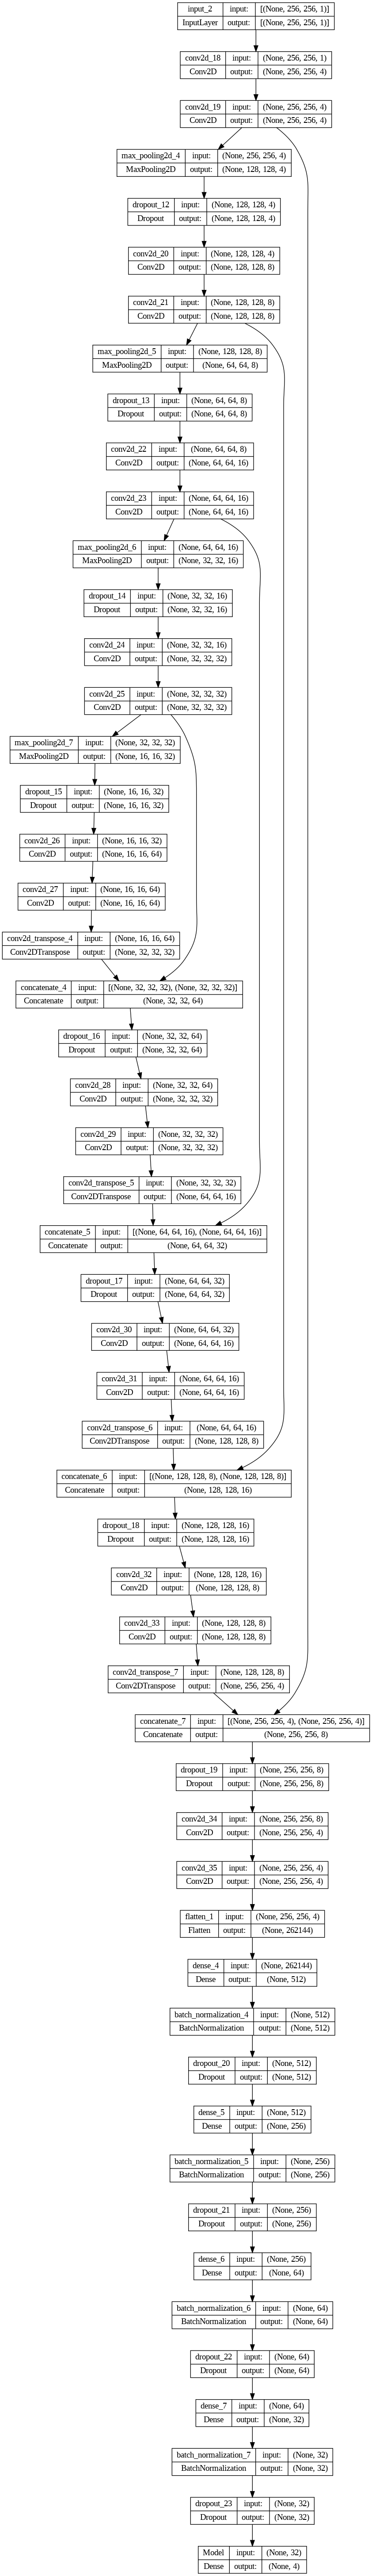

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, rankdir='TB', show_layer_names=True)

Realizamos el entrenamiento con 10% de los datos para validación.

In [ ]:
#10 % of the training data will be used to validate the training
start_time = time.time()

validation_portion = 0.1
batch_size=128
num_epochs = 50

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir="logs/model", histogram_freq=1)

history = model.fit(x=x_train, y=train_y, epochs=num_epochs, batch_size=batch_size, \
                            validation_split=validation_portion, shuffle=True,
                            callbacks=[tensorboard_callback], verbose=1)

end_time = time.time()
print("Time for training: {:10.4f}s".format(end_time - start_time))

Epoch 1/50
12/12 [==============================] - 18s 1s/step - loss: 1.5211 - accuracy: 0.4439 - val_loss: 1.3891 - val_accuracy: 0.2062
Epoch 2/50
12/12 [==============================] - 12s 1s/step - loss: 1.1524 - accuracy: 0.5547 - val_loss: 1.3878 - val_accuracy: 0.2062
Epoch 3/50
12/12 [==============================] - 12s 1s/step - loss: 0.9387 - accuracy: 0.6418 - val_loss: 1.3858 - val_accuracy: 0.2125
Epoch 4/50
12/12 [==============================] - 13s 1s/step - loss: 0.8625 - accuracy: 0.6718 - val_loss: 1.3840 - val_accuracy: 0.2625
Epoch 5/50
12/12 [==============================] - 13s 1s/step - loss: 0.8209 - accuracy: 0.6787 - val_loss: 1.3837 - val_accuracy: 0.2625
Epoch 6/50
12/12 [==============================] - 12s 1s/step - loss: 0.7519 - accuracy: 0.7171 - val_loss: 1.3810 - val_accuracy: 0.2625
Epoch 7/50
12/12 [==============================] - 12s 1s/step - loss: 0.6876 - accuracy: 0.7526 - val_loss: 1.3750 - val_accuracy: 0.2625
Epoch 8/50
12/12 [==

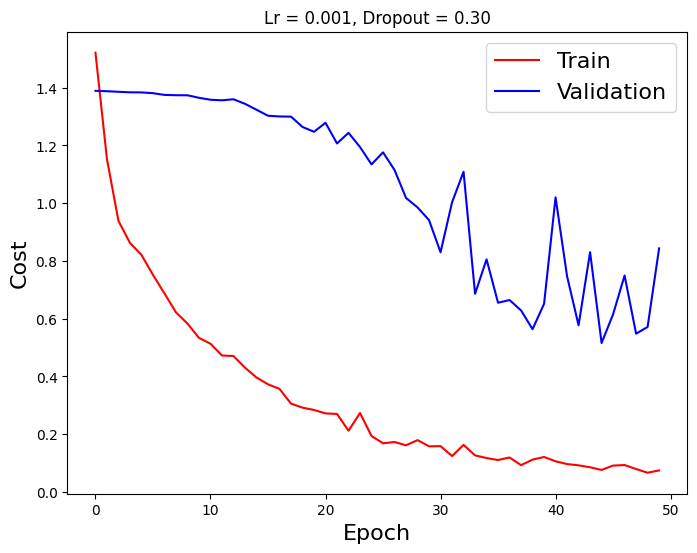

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.title('Lr = 0.001, Dropout = 0.30')
plt.ylabel('Cost', size=16)
plt.xlabel('Epoch',size=16)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=16)
plt.show()

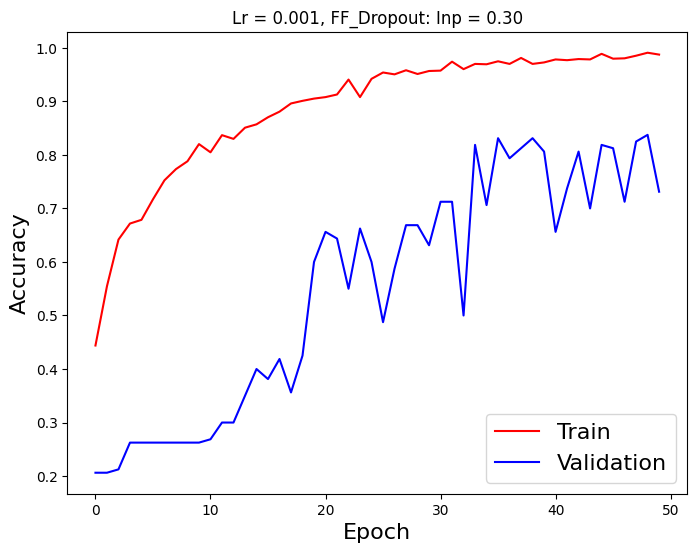

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(history.history['accuracy'], color='red')
plt.plot(history.history['val_accuracy'], color='blue')
plt.title('Lr = 0.001, FF_Dropout: Inp = 0.30')
plt.ylabel('Accuracy', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='lower right', fontsize=16)
plt.show()

In [ ]:
evaluations = model.evaluate(x = x_test, y = test_y)

print ("Loss = " + str(evaluations[0]))
print ("Test Accuracy = " + str(evaluations[1]))

10/10 [==============================] - 0s 38ms/step - loss: 1.2141 - accuracy: 0.6169
Loss = 1.2141071557998657
Test Accuracy = 0.6168830990791321


Hubo problemas para implementar bien esta arquitectura desde la cantidad de imágenes que se podían utilizar, la misma arquitectura utilizada no tenía tantos filtros como está plantada originalmente. Con más poder de cómputo se puden obtener mejores resultados.